# Weather and the MBTA #

## Motivation ##

This year, Boston has seen unprecedented levels of snow. As expected, it has caused a transportation nightmare between the congestion, delays, and cancelations. It has been so chaotic that the Boston MBTA chief has decided to step down due to public pressure. With such a rare opportunity, we decided to concentrate on the affects of snow on ridership.

## Methodology ##

### Setup ###

In [106]:
# Libraries.
import os
import datetime

import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn import cross_validation, grid_search
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set_context("paper")
% matplotlib inline

### Data Wrangling ###

#### MBTA ####

The MBTA provided us with entry data for each station at 15 minute intervals. After some wrangling, our base data set was composed of a ***stations*** data set and a ***gate count*** data set.

##### Stations #####

The station data set contained basic information for each station. One row corresponded to one station. Some of the data, in particular the latitude and longitude, was scraped from the web.

- ***stationid***: The unique identifier for the station.
- ***name***: The full name of the station station.
- ***line_1***: The primary line of the station (red/green/blue/orange).
- ***line_2***: The secondary line of the station (red/green/blue/orange). Only a few stations, such as park street (green/red line), had a value for this field.
- ***lat***: The latitude of the station.
- ***lon***: The longitude of the station.

In [3]:
stations = pd.read_csv('../../../data/stations.csv', low_memory=False)
stations.head()

,stationid,name,line_1,line_2,lat,lon
0,1002,Andrew Square,Red,NaN,42.329550,-71.056960
1,1004,JFK/U Mass,Red,NaN,42.321438,-71.052393
2,1005,North Quincy,Red,NaN,42.274816,-71.029176
3,1006,Wollaston,Red,NaN,42.265615,-71.019402
4,1007,Quincy Center,Red,NaN,42.250879,-71.004798


##### Gate Count #####

The gate count data set contained basic information for entries at each station. One row corresponded to the number of entries at a particular 15 minute interval for a station.

- ***locationid***: The unique identifier for the station.
- ***entries***: The number of entries for 15 minute interval.
- ***exits***: The number of exits for the 15 minute interval (NOT USED - exists are unreliable due to the nature of the system).
- ***service_day***: The actual day the service started (services on weekends can run into the next day).
- ***service_datetime***: The 15 minute interval where the entries/exists were aggregated.

In [4]:
gatecounts = pd.read_csv('../../../data/gatecounts.csv', low_memory=False)
gatecounts.head()

,locationid,entries,exits,service_day,service_datetime
0,1002,0,1,2013-01-01 00:00:00,2013-01-01 03:00:00
1,1002,1,0,2013-01-01 00:00:00,2013-01-01 05:00:00
2,1002,2,0,2013-01-01 00:00:00,2013-01-01 05:15:00
3,1002,3,0,2013-01-01 00:00:00,2013-01-01 05:30:00
4,1002,6,0,2013-01-01 00:00:00,2013-01-01 05:45:00


#### Weather ####

The weather data was obtained by scraping the [wunderground](http://www.wunderground.com/) API. Each row corresponded to the weather for a single day in Boston. A sample of the data is provided below. The most important feature was the "snow_fall" column, which was the recorded snow fall for that day.

In [5]:
weather = pd.read_csv('../../../data/weather.csv', low_memory=False)
weather.head()

,date,fog,hail,rain,snow,temp_min,temp_max,temp_mean,rain_fall,snow_fall,wind_speed,vis_min,vis_max,vis_mean
0,2012-01-01 00:00:00,0,0,1,0,39,52,46,0.01,0,9,9,10,10
1,2012-01-02 00:00:00,0,0,1,0,34,50,42,0.01,0,14,10,10,10
2,2012-01-03 00:00:00,0,0,0,0,14,35,25,0.00,0,15,10,10,10
3,2012-01-04 00:00:00,0,0,0,0,10,28,19,0.00,0,12,10,10,10
4,2012-01-05 00:00:00,0,0,0,0,25,39,32,0.00,0,12,10,10,10


#### Daily Data ####

The daily data set was an aggregation of entries per day for each station, with a few additional features. Sparing the details on how we generated these additional features (please refer to the ***features*** section of our repository), some important ones to recognize are:

- ***entries_weeks_ago_1***: The number of entries for this station on the same day one week ago.
- ***snow_fall***: The amount of snow the fell for that day, in inches.
- ***snow_accum***: The amount of snow accumulated up to the current day. The snow accumulation was calculated using a quasi-linear decay function based on the snow fall of the previous two weeks.
- ***dist_to_center***: The distance (in kilometers) to the center of the city (city hall).

#### Daily Data w/o Holidays ####

After some thorough analysis, we decided that "holidays" had no consistent pattern. We decided to consider them "extreme outliers" and removed them from our base data set (future analysis would be necessary for holidays). The "holidays" we removed were:

- New Years Eve
- New Years Day
- Boston Marathon
- Fourth of July
- Boston Move Out Day (September 1st)
- Labor Day
- Veteran's Day
- Thanksgiving
- Black Friday
- Christmas Week (12/25, 12/26, 12/27).

#### Daily Data w/o Weekends ####

After some thorough analysis, we decided that weekends and weekdays had two completely seperate patterns. We wanted to assist the MBTA in the greatest way possible and concentrated on weekdays, removing weekends from our base data set (future analysis would be necessary for weekends).

#### Final Data ####

Our final data set consisted of daily entries for each station, exluding holidays and weekends.

In [5]:
data_original = mbta_daily_noholidays_noweekends = pd.read_csv('../../../data/mbta_daily_weather_games_noholidays_weekdays.csv', low_memory=False).reset_index(drop=True)
print("Rows: " + str(data.shape[0]))
print("Cols: " + str(data.shape[1]))
data_original.head()

Rows: 32547
Cols: 50


,locationid,service_day,entries,name,line_1,line_2,lat,lon,service_datetime,fog,...,snow_fall_predict,snow_accum,snow_accum_predict,dist_to_center,entries_weeks_ago_1,entries_weeks_ago_2,entries_weeks_ago_3,bruins_game,celtics_game,sox_game
0,1002,2013-01-03 00:00:00,5733,Andrew Square,Red,NaN,42.329550,-71.056960,2013-01-03 05:00:00,0,...,0,0,0,3.404767,NaN,NaN,NaN,0,0,0
1,1004,2013-01-03 00:00:00,5842,JFK/U Mass,Red,NaN,42.321438,-71.052393,2013-01-03 04:45:00,0,...,0,0,0,4.328881,NaN,NaN,NaN,0,0,0
2,1005,2013-01-03 00:00:00,6139,North Quincy,Red,NaN,42.274816,-71.029176,2013-01-03 03:15:00,0,...,0,0,0,9.777437,NaN,NaN,NaN,0,0,0
3,1006,2013-01-03 00:00:00,4028,Wollaston,Red,NaN,42.265615,-71.019402,2013-01-03 05:00:00,0,...,0,0,0,10.976943,NaN,NaN,NaN,0,0,0
4,1007,2013-01-03 00:00:00,7331,Quincy Center,Red,NaN,42.250879,-71.004798,2013-01-03 04:30:00,0,...,0,0,0,12.909591,NaN,NaN,NaN,0,0,0


## Analysis ###

###Linear Modeling of Ridership Based on Snowfall ####

##### Introduction #####

After some cursory visualization of ridership for days where it snowed, we saw that more snow typically meant less passengers using the rail system. The website features an interactive visualization of a day's ridership for one station and a given amount of snowfall as a time series. The analysis below will focus instead on modeling the relationship between snowfall as the dependent variable and the fraction of normal ridership at the station as the response variable.



In [6]:
# remove some of the columns
data=data_original.copy()[['locationid','service_day','entries','snow','snow_fall','service_datetime']]
data.head()

,locationid,service_day,entries,snow,snow_fall,service_datetime
0,1002,2013-01-03 00:00:00,5733,0,0,2013-01-03 05:00:00
1,1004,2013-01-03 00:00:00,5842,0,0,2013-01-03 04:45:00
2,1005,2013-01-03 00:00:00,6139,0,0,2013-01-03 03:15:00
3,1006,2013-01-03 00:00:00,4028,0,0,2013-01-03 05:00:00
4,1007,2013-01-03 00:00:00,7331,0,0,2013-01-03 04:30:00


In [7]:
# create a month column

def month_col(date):
    return int(date.split(' ')[0].split('-')[1])

data['month']=map(month_col,data['service_day'].values)
data.head()

,locationid,service_day,entries,snow,snow_fall,service_datetime,month
0,1002,2013-01-03 00:00:00,5733,0,0,2013-01-03 05:00:00,1
1,1004,2013-01-03 00:00:00,5842,0,0,2013-01-03 04:45:00,1
2,1005,2013-01-03 00:00:00,6139,0,0,2013-01-03 03:15:00,1
3,1006,2013-01-03 00:00:00,4028,0,0,2013-01-03 05:00:00,1
4,1007,2013-01-03 00:00:00,7331,0,0,2013-01-03 04:30:00,1


In [8]:
# convert service datetime into an integer hour and decimal representation of minutes
def time_frac(dt):
    time_string=dt.split(' ')[1]
    
    hour=int(time_string.split(':')[0])
    minute_frac=int(time_string.split(':')[1])/60.
    
    return hour+minute_frac

data['servicetime_fraction']=map(time_frac,data['service_datetime'].values)
data.head()

,locationid,service_day,entries,snow,snow_fall,service_datetime,month,servicetime_fraction
0,1002,2013-01-03 00:00:00,5733,0,0,2013-01-03 05:00:00,1,5.00
1,1004,2013-01-03 00:00:00,5842,0,0,2013-01-03 04:45:00,1,4.75
2,1005,2013-01-03 00:00:00,6139,0,0,2013-01-03 03:15:00,1,3.25
3,1006,2013-01-03 00:00:00,4028,0,0,2013-01-03 05:00:00,1,5.00
4,1007,2013-01-03 00:00:00,7331,0,0,2013-01-03 04:30:00,1,4.50


In [9]:
data=data[['locationid','service_day','entries','snow','snow_fall','month','servicetime_fraction']]

###Snow_change function
Below is a function that will do a lot of the heavy lifting for this part of the analysis. Given a station_id and a time window, along with a few other parameters to tune output, snow_change() calculates the change in ridership for a given amount of snowfall.

For example, let's assume the very simplified case where 10 riders enter Kenmore station on a day with no snow, also assuming the day is in October-March in order to reduce any seasonal trends. This will be our reference value. Suppose we observed a day with 2 inches of snowfall and only 8 riders entered Kenmore station over the whole day. This will plot a point at coordinates (2, .8) since a day with 2 inches of snow had 80% of the usual ridership.

In [11]:
'''
Fit a linear function of snowfall on the entries for a given station.

begin/end_time: set window of interest for workday. Set to normal AM rush hour

percent: T/F to show y axis as percent of avg entry w/o snow. Otherwise, raw numbers are used and y-axis will
 suffer if this function is used to plot linear fit on multiple stations whose entries differ by large amounts
 
plot: T/F whether or not to plot

plot_type: both, line, or scatter for what to display
***
returns: parameters of line of best fit
'''

def snow_change(station_id,begin_time=6.5,end_time=9.5,percent=False,plot_type='both',plot=True):
    #get subset of station
    station_records=data[data['locationid']==station_id]
    
    #want to subset the dataframe to only include months in which there may be snow
    # don't want the seasonal trends of Summer, Spring, early Fall to skew my values for when there 
    # is no snow
    station_records=station_records[(station_records['month']>=10) |(station_records['month']<=3)]

    if(percent):
        #get subset of snow records
        no_snow=station_records[station_records['snow']==False]
        mean_ridership=np.mean(no_snow[['service_day','entries']].groupby('service_day').agg(np.sum)['entries'])
        #print mean_ridership
        
    station_records=station_records[station_records['snow']==True]   
    
    station_records=station_records[station_records['snow_fall']<=20]
    station_grouping=station_records[['service_day','entries','snow_fall']].groupby('service_day')
    
    snowfall_vec=station_grouping.agg(np.median)['snow_fall']
    entries_vec=station_grouping.agg(np.sum)['entries']
    
    # Going to assume that for 0 inches of snow, ridership==1 by fixing the intercept at 0. Will need
    # to shift ridership ratios down by 1 unit.
    p2=sklearn.linear_model.LinearRegression(fit_intercept=False)
    
    if(percent):
        #p = np.polyfit(snowfall_vec.values,entries_vec.values*1./mean_ridership,1)
        p2.fit(snowfall_vec.values[:,np.newaxis],(entries_vec.values*1./mean_ridership)-1)
    else:
        #p = np.polyfit(snowfall_vec.values,entries_vec.values,1)
        p2.fit(snowfall_vec.values[:,np.newaxis],entries_vec.values-1)
        
    x_vals=np.linspace(0,20,len(snowfall_vec.values))
    if plot:
        if (plot_type=='scatter')| (plot_type=='both'):
            if percent:
                plt.scatter(snowfall_vec.values,entries_vec.values*1./mean_ridership,alpha=0.3,color='r')
            else:
                plt.scatter(snowfall_vec.values,entries_vec.values,alpha=0.3,color='r')
        if (plot_type=='line')| (plot_type=='both'):
            
            ys=p2.predict(x_vals[:,np.newaxis])
            plt.plot( x_vals, ys+1, alpha=0.75,label="station: "+str(station_id))
            #plt.plot(x_vals,p[0]*x_vals+p[1],alpha=0.75,label="station: "+str(station_id)) # A red solid line

        plt.xlabel('Inches of Snow')
        plt.ylabel('Entries')
        plt.title('Snowfall vs Entries for station: '+str(station_id))
    #for day in station_grouping:
        
    return [snowfall_vec.values,p2,(entries_vec.values*1./mean_ridership)]



####Comment:

I removed the days with more than 20 inches of snow because they were very few yet significantly affected the linear models fit to the data. Atypical amounts of snowfall, like we experienced during January and February of 2015, clearly affect both ridership and performance of the MBTA, but we may not want to build a model to encompass those events at the expense of accurately modeling more typical amounts of snowfall.

###Effect of Snowfall on AM Rush Hour Ridership

Below, we see a series of points where the x axis represents the amount of snow on a given day and the y-axis is the ratio of total ridership on that day to the ridership of at that station on days without snow. Presenting the data in this way helps show the effect of snowfall across stations without worrying about the difference in volume between stations. Also plotted is the linear model fit using least squares. 

Note: Keep in mind that we are only considering the AM rush hour period of 6:30 a.m. to 9:30 p.m. This analysis can easily be extended to the whole day, but we thought this was an important part of the day that deserved its own focus.

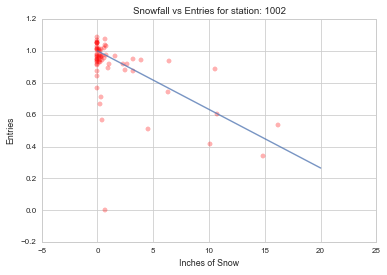

In [12]:
t=snow_change(1002,percent=True,plot_type='both') 


We can perform the analysis above on all stations to get an idea how the whole MBTA system is affected by snowfall

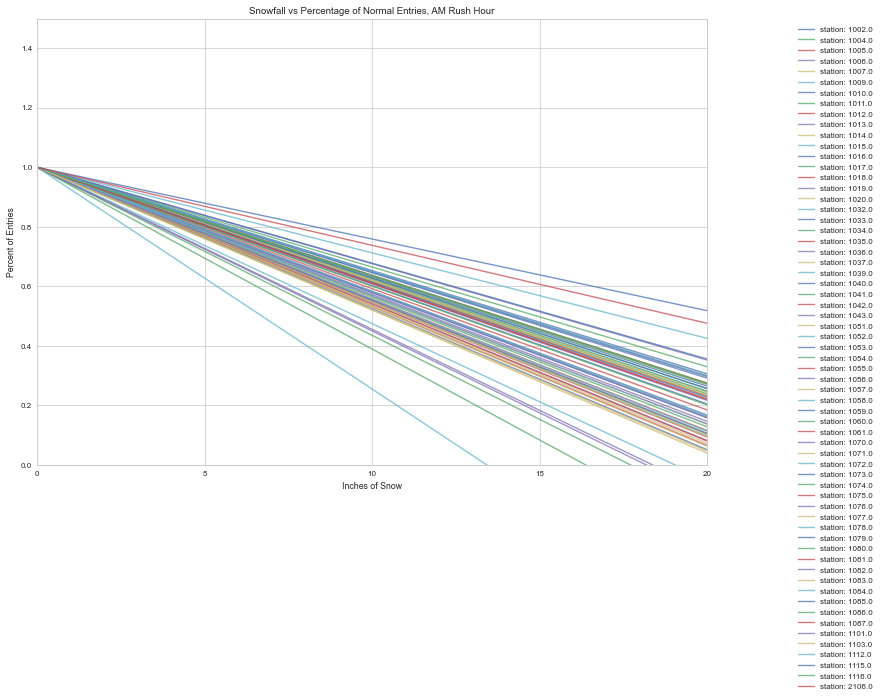

In [13]:
plt.figure(figsize=(12,8))

models=[]
for station in list(data['locationid'].unique()):
    #print station
    t=snow_change(station,percent=True,begin_time=5.,end_time=24.,plot_type='line')
    models.append(t[1])
    plt.xlabel('Inches of Snow')
    plt.ylabel('Percent of Entries')
    plt.ylim([0,1.5])
    #plt.title('Snowfall vs Entriesw/o Snow for station: '+str(station_id))
    
plt.title('Snowfall vs Percentage of Normal Entries, AM Rush Hour')
plt.legend(bbox_to_anchor=(1.1, .9),bbox_transform=plt.gcf().transFigure)
plt.show()

###Comment:
In order to reduce the clutter on the plot, I've averaged the models below and included a shaded region representing one standard deviation from the mean model value at each point.

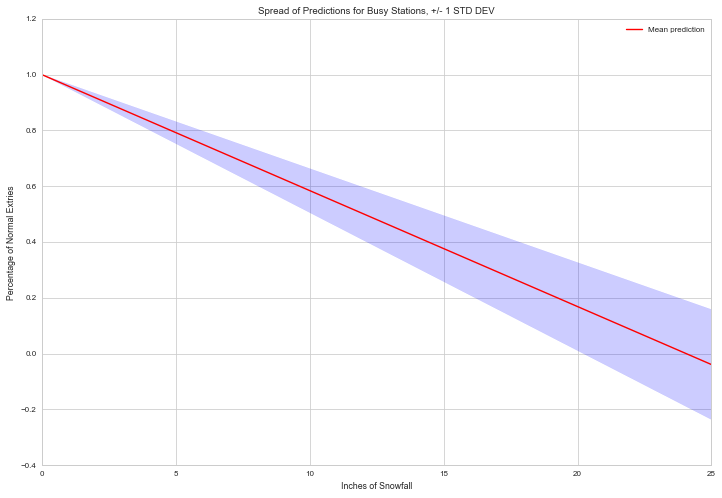

In [14]:
x_values=np.linspace(0,25,100)

pred=np.zeros([len(models),len(x_values)])
plt.figure(figsize=(12,8))

for mod in range(len(models)):
    
    pred[mod]= models[mod].predict(x_values[:,np.newaxis])+1
    #plt.plot( x_vals, ys+1, alpha=0.75,label="station: "+str(station_id))
    
# Group the predictions according to their x_value
pred_per_x=pred.transpose()

mean_pred=np.mean(pred_per_x,axis=1)
std_pred=np.std(pred_per_x,axis=1)

upper=(mean_pred + std_pred)
lower=(mean_pred - std_pred)

plt.plot( x_values, mean_pred, color='r', label='Mean prediction')
plt.fill_between(x_values, upper, lower, color='b', alpha=.2,label='1 std dev')
plt.xlabel('Inches of Snowfall')
plt.ylabel('Percentage of Normal Extries')
plt.title('Spread of Predictions for Busy Stations, +/- 1 STD DEV')
plt.legend()
plt.show()


####Comments:

It's clear that snowfall has an adverse effect on ridership, but by aggregating all of the stations into one plot, we lose any intuition about how ridership changes at different stations. Consider the question, "Does snow affect stations outside the city differently than those close to downtown?" We lose the ability to answer this question when we aggregate stations. Analysis in the introductory notebook showed that stations exhibit different ridership patterns and different volumes of ridership so a broad-reaching analysis like the one above may not be the best to draw actionable conclusions.

###Snowfall Ridership based on Distance From City Hall

The following analysis follows from the station grouping derived in the notebook concerning the identification of 'similar stations'. The analysis suggested that stations usually have ridership patterns similar to other stations who are equally as far from Boston City Hall. The station groupings are below..

![grouping](group_text.png)

The plot of linear models above for all stations shows a large amount of variability as evidenced by the different sloped lines. It would be interesting to see if we can reduce the clutter by considering the linear models *within* the groupings above. For example, maybe the variability observed above is due to a subset of stations losing more ridership during snowstorms than the others.


In [15]:
##read in a csv that contains station grouping info from the Similar Stations section
station_info=pd.read_csv('../../../data/Stations_clean.csv')

group_0_ids=list(station_info[station_info['grouping']==0]['stationid'].values)
group_1_ids=list(station_info[station_info['grouping']==1]['stationid'].values)
group_2_ids=list(station_info[station_info['grouping']==2]['stationid'].values)

station_info.head()

IOError: File ../../../data/Stations_clean.csv does not exist

###Group 0 stations, Closer to City Hall

In [171]:
#create a dict to hold the slopes from each model, separated into my grouping, for further analysis
slopes={0:[],1:[],2:[]}

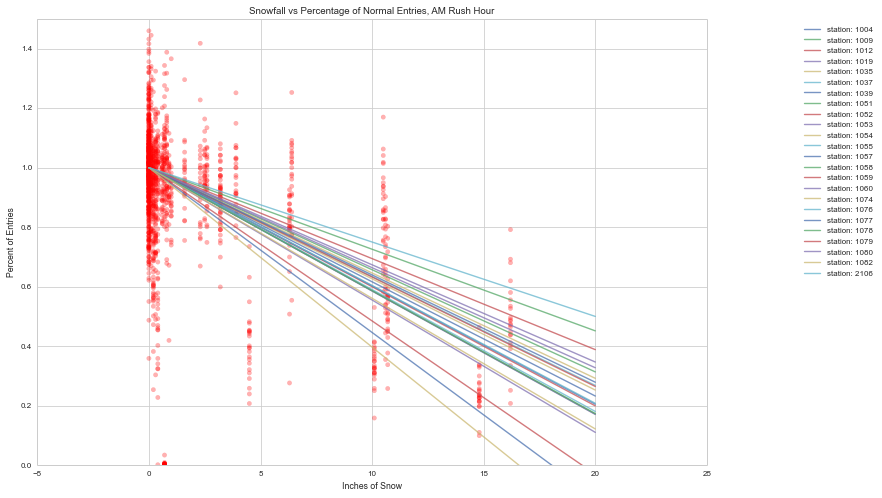

In [172]:

models=[]
snowfall=list([])
ridership=list([])
plt.figure(figsize=(12,8))

for station in group_0_ids:
    #print station
    t=snow_change(station,percent=True,begin_time=5.,end_time=24.,plot_type='both')
    models.append(t[1])
    
    # can compute the slope by finding the prediction for one inch of snow since the intercept is fixed at y=1
    slopes[0].append(t[1].predict([1]))
    
    snowfall.append(t[0])
    ridership.append(t[2])
    plt.xlabel('Inches of Snow')
    plt.ylabel('Percent of Entries')
    plt.ylim([0,1.5])
plt.title('Snowfall vs Percentage of Normal Entries, AM Rush Hour')
plt.legend(bbox_to_anchor=(1.1, .9),bbox_transform=plt.gcf().transFigure)
plt.show()


####Comments:

Look at the output of the plot below. We see that for stations near Boston City Hall, the linear model predicts that for 4 inches of snowfall, stations in this grouping will have 84.1% of the average ridership. Each point also has error bars corresponding to the variance in ridership for points with the same amount of snowfall.

Percentage of ridership for 4.0404040404 inches of snow: 0.841007881228


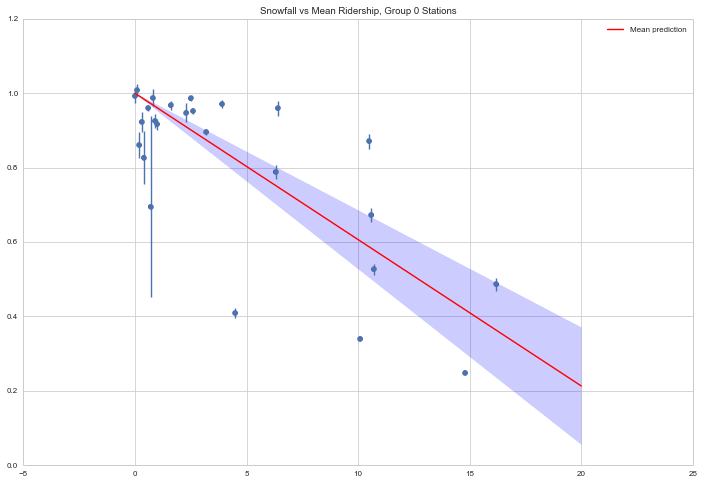

In [153]:

def temp_mean(x):
        return np.mean(x)
def temp_var(x):
    return np.var(x)

snowfall_vector=list([])
ride_vector=list([])
plt.figure(figsize=(12,8))

#using downtown and state st, high correlation
for stat in group_0_ids:
    
    c=snow_change(stat,percent=True,plot_type='line',plot=False)

    snowfall_vector+=list(c[0])
    ride_vector+=list(c[2])

d=pd.DataFrame(zip(snowfall_vector,ride_vector),columns=['snowfall','ridership'])
    
summary=d.groupby('snowfall').agg([temp_mean,temp_var,len])


plt.title('Snowfall vs Mean Ridership, Group 0 Stations')
plt.scatter(summary.index,summary['ridership']['temp_mean'])
plt.errorbar(summary.index,summary['ridership']['temp_mean'],yerr=summary['ridership']['temp_var'],fmt='o')
###### plot model bands
x_values=np.linspace(0,20,100)

pred=np.zeros([len(models),len(x_values)])

for mod in range(len(models)):
    
    pred[mod]= list(models[mod].predict(x_values[:,np.newaxis])+1)
    
# Group the predictions according to their x_value
pred_per_x=pred.transpose()

mean_pred=np.mean(pred_per_x,axis=1)
std_pred=np.std(pred_per_x,axis=1)

upper=(mean_pred + std_pred)
lower=(mean_pred - std_pred)

plt.plot( x_values, mean_pred, color='r', label='Mean prediction')
plt.fill_between(x_values, upper, lower, color='b', alpha=.2,label='1 std dev')
plt.legend()

means=summary['ridership']['temp_mean']
var=summary['ridership']['temp_var']
num=summary['ridership']['len']

print 'Percentage of ridership for '+str(x_values[20])+' inches of snow: '+str(mean_pred[20])


###Group 1 Stations, Far Away from City Hall

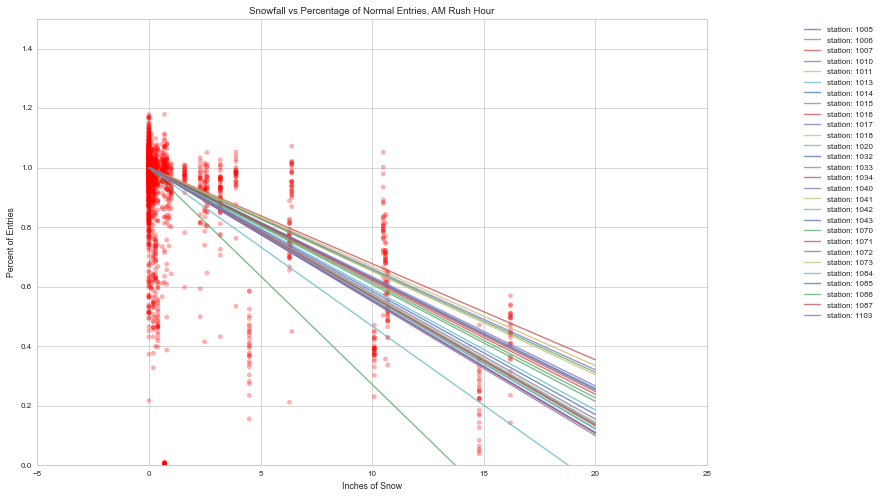

In [173]:

models=[]
snowfall=list([])
ridership=list([])
plt.figure(figsize=(12,8))

for station in group_1_ids:
    #print station
    t=snow_change(station,percent=True,begin_time=5.,end_time=24.,plot_type='both')
    models.append(t[1])
    
    # can compute the slope by finding the prediction for one inch of snow since the intercept is fixed at y=1
    slopes[1].append(t[1].predict([1]))
    
    snowfall.append(t[0])
    ridership.append(t[2])
    plt.xlabel('Inches of Snow')
    plt.ylabel('Percent of Entries')
    plt.ylim([0,1.5])
plt.title('Snowfall vs Percentage of Normal Entries, AM Rush Hour')
plt.legend(bbox_to_anchor=(1.1, .9),bbox_transform=plt.gcf().transFigure)
plt.show()


Percentage of ridership for 4.0404040404 inches of snow: 0.831768360794


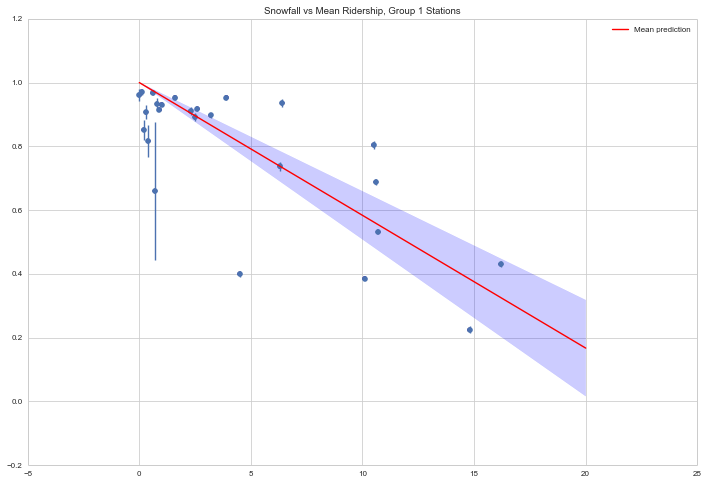

In [155]:
snowfall_vector=list([])
ride_vector=list([])
plt.figure(figsize=(12,8))

#using downtown and state st, high correlation
for stat in group_1_ids:
    
    c=snow_change(stat,percent=True,plot_type='line',plot=False)

    snowfall_vector+=list(c[0])
    ride_vector+=list(c[2])

d=pd.DataFrame(zip(snowfall_vector,ride_vector),columns=['snowfall','ridership'])
    
summary=d.groupby('snowfall').agg([temp_mean,temp_var,len])


plt.title('Snowfall vs Mean Ridership, Group 1 Stations')
plt.scatter(summary.index,summary['ridership']['temp_mean'])
plt.errorbar(summary.index,summary['ridership']['temp_mean'],yerr=summary['ridership']['temp_var'],fmt='o')
###### plot model bands
x_values=np.linspace(0,20,100)

pred=np.zeros([len(models),len(x_values)])

for mod in range(len(models)):
    
    pred[mod]= list(models[mod].predict(x_values[:,np.newaxis])+1)
    
# Group the predictions according to their x_value
pred_per_x=pred.transpose()

mean_pred=np.mean(pred_per_x,axis=1)
std_pred=np.std(pred_per_x,axis=1)

upper=(mean_pred + std_pred)
lower=(mean_pred - std_pred)

plt.plot( x_values, mean_pred, color='r', label='Mean prediction')
plt.fill_between(x_values, upper, lower, color='b', alpha=.2,label='1 std dev')
plt.legend()

means=summary['ridership']['temp_mean']
var=summary['ridership']['temp_var']
num=summary['ridership']['len']

print 'Percentage of ridership for '+str(x_values[20])+' inches of snow: '+str(mean_pred[20])


####Comments:

Note that the mean prediction of ridership for 4 inches of snow for these stations further away from Boston City Hall is 83.1%, approximately 1% less than what we saw for the stations in the heart of the city. This early analysis suggests that change in ridership due to snowfall doesn't vary between stations of varying distances from City Hall

####Group 2 Stations, Middle-distance from the city

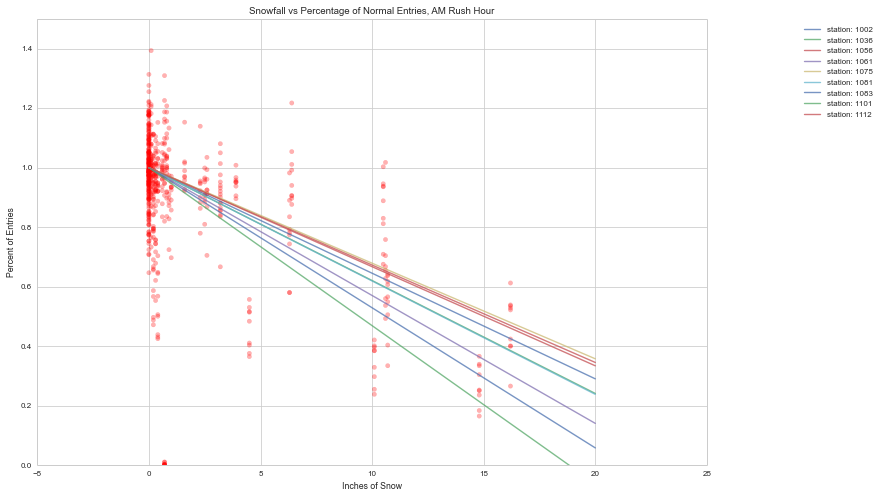

In [174]:

models=[]
snowfall=list([])
ridership=list([])
plt.figure(figsize=(12,8))

for station in group_2_ids:
    #print station
    t=snow_change(station,percent=True,begin_time=5.,end_time=24.,plot_type='both')
    models.append(t[1])
    
    # can compute the slope by finding the prediction for one inch of snow since the intercept is fixed at y=1
    slopes[2].append(t[1].predict([1]))
    
    snowfall.append(t[0])
    ridership.append(t[2])
    plt.xlabel('Inches of Snow')
    plt.ylabel('Percent of Entries')
    plt.ylim([0,1.5])
plt.title('Snowfall vs Percentage of Normal Entries, AM Rush Hour')
plt.legend(bbox_to_anchor=(1.1, .9),bbox_transform=plt.gcf().transFigure)
plt.show()


Percentage of ridership for 4.0404040404 inches of snow: 0.841580922566


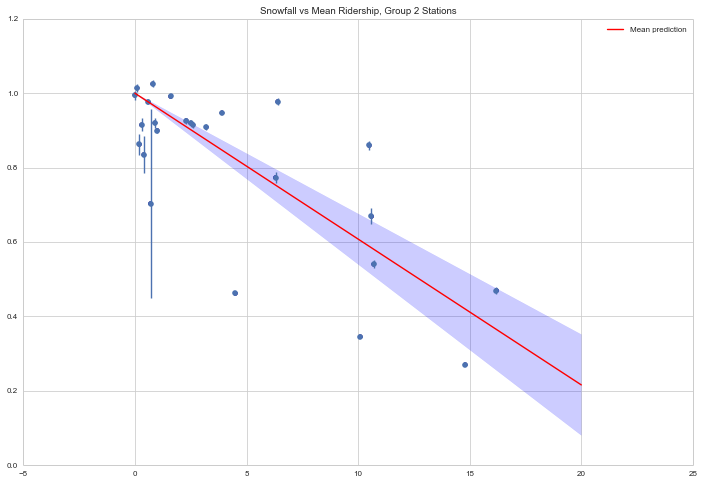

In [162]:
snowfall_vector=list([])
ride_vector=list([])
plt.figure(figsize=(12,8))

#using downtown and state st, high correlation
for stat in group_2_ids:
    
    c=snow_change(stat,percent=True,plot_type='line',plot=False)

    snowfall_vector+=list(c[0])
    ride_vector+=list(c[2])

d=pd.DataFrame(zip(snowfall_vector,ride_vector),columns=['snowfall','ridership'])
    
summary=d.groupby('snowfall').agg([temp_mean,temp_var,len])


plt.title('Snowfall vs Mean Ridership, Group 2 Stations')
plt.scatter(summary.index,summary['ridership']['temp_mean'])
plt.errorbar(summary.index,summary['ridership']['temp_mean'],yerr=summary['ridership']['temp_var'],fmt='o')
###### plot model bands
x_values=np.linspace(0,20,100)

pred=np.zeros([len(models),len(x_values)])

for mod in range(len(models)):
    
    pred[mod]= list(models[mod].predict(x_values[:,np.newaxis])+1)
    
# Group the predictions according to their x_value
pred_per_x=pred.transpose()

mean_pred=np.mean(pred_per_x,axis=1)
std_pred=np.std(pred_per_x,axis=1)

upper=(mean_pred + std_pred)
lower=(mean_pred - std_pred)

plt.plot( x_values, mean_pred, color='r', label='Mean prediction')
plt.fill_between(x_values, upper, lower, color='b', alpha=.2,label='1 std dev')
plt.legend()

means=summary['ridership']['temp_mean']
var=summary['ridership']['temp_var']
num=summary['ridership']['len']

print 'Percentage of ridership for '+str(x_values[20])+' inches of snow: '+str(mean_pred[20])


####Comment:###
The mean predicted value for 4 inches of snow for Group 2 stations is 84.15% which is more in line with what we saw for Group 0 stations near City Hall.

####Investigating the Slopes of the Models

The plots above provide valuable insight into how snowfal affects the AM rush hour for our grouping of the stations. However, we lose any information about the distribution of the linear models fit within each grouping upon averaging them into one model for the whole group. Below we used box plots to examine the distribution snowfall coefficients within each grouping. In non-statistical terms, the plots show the distribution of how snow affects all stations within a group. 

The three box plots do not vary much, suggesting that stations lose ridership at similar rates during snowstorms, regardless of their distance from City Hall. The median of Group 1 box plot is slightly lower than that of the other two groups, reaffirming what we saw above when Group 1 stations maintained 83.1% percent of ridership for 5 inches of snow compared to 84% for the other station groupings.


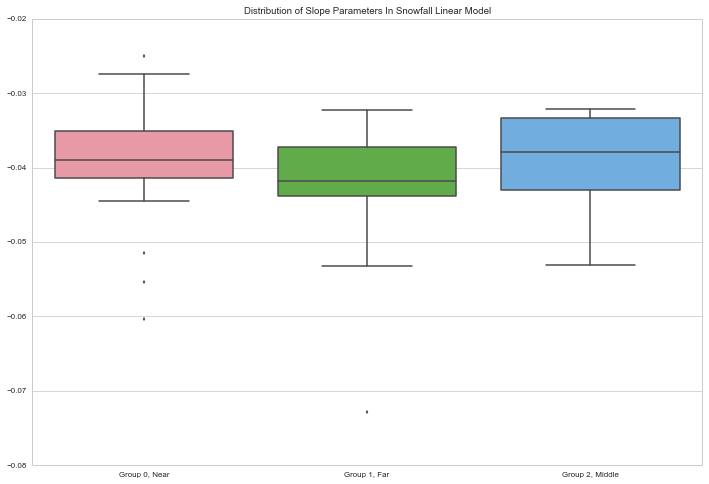

In [175]:
plt.figure(figsize=(12,8))
sns.boxplot([slopes[0],slopes[1],slopes[2]],names=["Group 0, Near",'Group 1, Far','Group 2, Middle'])
plt.title('Distribution of Slope Parameters In Snowfall Linear Model')
plt.show()

####Conclusion:####

Initial analysis shows clear evidence that less people ride the rail system when it's snowing. Individual stations are affected differently in terms of how much ridership they lose as a result of snow. However, the analysis above does not suggest that stations further from the city significantly lose more ridership due to snow than stations closer to the city. 

In terms of building a comprehensive predictive model of ridership, the analysis suggests that we do not need to account for any interactive effects between snowfall and a station's distance from City Hall.


####  Prediction Improvement ####

##### Introduction #####

Changes in the accuracy of entry predictions are one way of determining the importance of snow to the MBTA. To do so, we can add snow "features" (or predictors) to a basic model (Linear Regression) and check for a reduction in the overall percent error of our predictions for each station. We can define percent error for each station as:

$$ station_{percent\ error} = \frac{|entries_{predicted} - entries_{actual}|}{entries_{actual}} * 100 $$

Once we have determined the percent error for each station, we can determine the overall average of errors:

$$ Total\ Average\ Error = \frac{1}{n} \sum^n_i{station^i_{percent\ error}} $$

##### Method Definitions #####

The following methods are used to help us generate a prediction model and determine the percent error for each station.

In [18]:
data = data_original.copy()

In [34]:
"""
Generates a prediction model for a given station with desired features.

This will return the best model based on 10 fold cross-validation with an 70/30 train/test split.

In addition, this will return the mean absolute error for all the entries in the test set, and any outliers
based on a given absolute error threshold.

Key arguments:

  station    -- The station to train on.
  cols       -- The columns in the station data frame that are considered features.
  predictor  -- The predictor to use (sklearn predictor)
  parameters -- The parameters for the preductor.
  rstate     -- The random state to use for the train/test split.

"""
def predict(station, features, predictor, parameters, rstate):
    # Copy the station so we don't manipulate the original.
    station = station.copy()
    
    # Get the columns of the dataframe.
    all_cols = list(station.columns)
    
    # Determine the indices of the columns.
    y_col_indices = [0] + list(np.where([col == 'entries' for col in all_cols])[0] + 1)
    x_col_indices = [0] + list(np.where([col in features for col in all_cols])[0] + 1)
    
    # Make sure none of the predictor fields are null.
    for col in features:
        station = station[pd.notnull(station[col])]
    
    # Remove any entries where no one was there (probably closed) or the entries appears to be
    #  extremely low (less than 1% of the mean).
    # We assume that any entries with less than 1% of the normal entries is having serious issues.
    min_entries = np.mean(station['entries']) * .005
    station = station[station['entries'] > min_entries]
    
    # Reset the station indices, we have to reset twice so the matrix values gets the index column.
    station = station.reset_index()
    station.drop('index', axis=1, inplace=True)
    station = station.reset_index()
    
    # Get the dataframe as a matrix where the first column is the index.
    matrix = station.values
    
    # Slice so the y only contains 2 column (index, entries)
    #  and the x is a matrix that contains the index and all the predictors.
    y = matrix[:,y_col_indices]
    x = matrix[:,x_col_indices]
    
    # Split the data set into a train and test.
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.3, random_state=rstate)
    
    # Convert the train and test sets into a format sklean fit() expects.
    x_train_fit = np.matrix(x_train[:,1:], dtype=np.float32)
    y_train_fit = np.array([v[0] for v in y_train[:,1:]], dtype=np.uint16)
    
    x_test_fit = np.matrix(x_test[:,1:], dtype=np.float32)
    y_test_fit = np.array([v[0] for v in y_test[:,1:]], dtype=np.uint16)
    
    # Train using a grid search based on the parameters provided.
    clf = grid_search.GridSearchCV(predictor, parameters, scoring='mean_squared_error', cv=10)
    clf.fit(x_train_fit, y_train_fit)
    
    # Determine what the best model was.
    model = clf.best_estimator_
    
    # Find the train/test data sets in the original station data frame.
    train_results = station.iloc[y_train[:,0]]
    test_results = station.iloc[y_test[:,0]]
    
    # Predict using the train/test set.
    train_results['prediction'] = model.predict(x_train_fit)
    test_results['prediction'] = model.predict(x_test_fit)
    
    # Determine the percent errors.
    train_results['error'] = np.abs(train_results['prediction'] - train_results['entries']) / train_results['entries']
    test_results['error'] = np.abs(test_results['prediction'] - test_results['entries']) / test_results['entries']
    
    return model, train_results, test_results

In [38]:
"""
Tests a station multiple times by running the prediction method with a different
random state.

Key arguments:

  station  -- The station to test for.
  cols     -- The columns in station to use as features.
  trials   -- The number of times to run predict (also the number of randomly generated test sets).

"""
def test_features(station, cols, error_threshold = 0.2, trials = 50):
    train_errors = np.zeros(trials)
    test_errors = np.zeros(trials)
    train_outliers = pd.DataFrame()
    test_outliers = pd.DataFrame()
    test_snowdays = pd.DataFrame()
    
    predictor = linear_model.LinearRegression()
    parameters = {}
    
    for rstate in xrange(trials):
        model, train_results, test_results = predict(station, cols, predictor, parameters, rstate)
        
        # Keep track of the train and test errors for this result.
        train_errors[rstate] = train_results['error'].mean()
        test_errors[rstate] = test_results['error'].mean()
        
        # Keep track of any "outliers" for both the train and test group, i.e. rows that were above the threshold.
        trial_train_outliers = train_results[train_results['error'] > error_threshold]
        trial_test_outliers = test_results[test_results['error'] > error_threshold]
        trial_test_snowdays = test_results[test_results['snow'] == 1]
        
        if len(train_outliers) == 0 and len(test_outliers) == 0 and len(test_snowdays) == 0:
            train_outliers = trial_train_outliers
            test_outliers = trial_test_outliers
            test_snowdays = trial_test_snowdays
        else:
            train_outliers = pd.concat([train_outliers, trial_train_outliers[~trial_train_outliers.isin(train_outliers.index)]])
            test_outliers = pd.concat([test_outliers, trial_test_outliers[~trial_test_outliers.isin(test_outliers.index)]])
            test_snowdays = pd.concat([test_snowdays, trial_test_snowdays[~trial_test_snowdays.isin(test_snowdays.index)]])
    
    return train_errors, test_errors, train_outliers, test_outliers, test_snowdays

##### A Simple Example #####

Lets step through a simple example of how the process works. For this simple example, we're going to predict the entries for Andrew Square.

In [39]:
andrew_square = data[data['locationid'] == 1002]

For a group of days (test set), we want to see how accruate we can predict the number of daily entries for Andrew Square using only the number of entries on the same day for the past two weeks.

E.g. If I was predicting the entries for Andrew Square on 2015-02-21, I would build a regression model only using the known entries on 2015-02-14 and 2015-02-07 as features.

The method below builds a model and predicts the entries for multiple test sets. We can than average the error for each snow day in the test set to determine the mean prediction error for Andrew Square on Snow Days.

In [162]:
train_errors, test_errors, train_outliers, test_outliers, test_snowdays = test_features(andrew_square, ['entries_weeks_ago_1', 'entries_weeks_ago_2'], .2, 50)
print("Average Percent Error for Days with Snow in Test Sets: " + str(np.abs(np.sum(test_snowdays['prediction']) - np.sum(test_snowdays['entries'])) / np.sum(test_snowdays['entries'])))

Average Percent Error for Days with Snow in Test Sets: 0.0618675105011


> _We can predict entries at Andrew Square on Snow Days with a 6% error rate._

We can also take a look at days in which the prediction model did not perform well.

In [164]:
test_snowdays[['locationid', 'name', 'service_day', 'snow_fall', 'snow_accum', 'entries', 'prediction', 'error']][test_snowdays.snow_fall > 8.0].head()

,locationid,name,service_day,snow_fall,snow_accum,entries,prediction,error
509,1002,Andrew Square,2015-02-09 00:00:00,14.8,22.9,2109,5652.169190,1.680023
259,1002,Andrew Square,2014-02-05 00:00:00,10.7,11.3,3771,5897.160982,0.563819
16,1002,Andrew Square,2013-02-08 00:00:00,10.1,10.7,2615,6181.689492,1.363935
509,1002,Andrew Square,2015-02-09 00:00:00,14.8,22.9,2109,5674.864078,1.690784
509,1002,Andrew Square,2015-02-09 00:00:00,14.8,22.9,2109,5641.304336,1.674872


As we can see, the days in which we had snow there was a significant error. Lets take a look at some of the snow days in detail.

In [124]:
test_snowdays[test_snowdays.snow_fall > 8.0].head()

,index,locationid,service_day,entries,name,line_1,line_2,lat,lon,service_datetime,...,snow_accum_predict,dist_to_center,entries_weeks_ago_1,entries_weeks_ago_2,entries_weeks_ago_3,bruins_game,celtics_game,sox_game,prediction,error
509,509,1002,2015-02-09 00:00:00,2109,Andrew Square,Red,NaN,42.32955,-71.05696,2015-02-09 04:30:00,...,14.4,3.404767,3327,5732,3713,0,0,0,5652.169190,1.680023
259,259,1002,2014-02-05 00:00:00,3771,Andrew Square,Red,NaN,42.32955,-71.05696,2014-02-05 04:45:00,...,5.8,3.404767,6084,4455,6187,0,0,0,5897.160982,0.563819
16,16,1002,2013-02-08 00:00:00,2615,Andrew Square,Red,NaN,42.32955,-71.05696,2013-02-08 04:15:00,...,20.3,3.404767,6660,5822,6295,0,0,0,6181.689492,1.363935
509,NaN,1002,2015-02-09 00:00:00,2109,Andrew Square,Red,NaN,42.32955,-71.05696,2015-02-09 04:30:00,...,14.4,3.404767,3327,5732,3713,0,0,0,5674.864078,1.690784
509,NaN,1002,2015-02-09 00:00:00,2109,Andrew Square,Red,NaN,42.32955,-71.05696,2015-02-09 04:30:00,...,14.4,3.404767,3327,5732,3713,0,0,0,5641.304336,1.674872


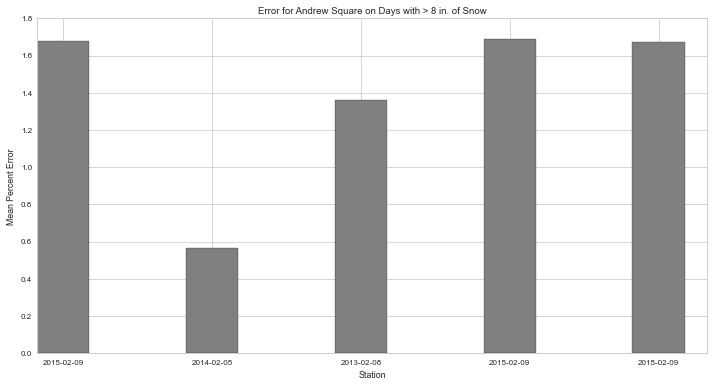

In [123]:
# Select a few days in which the snow was greater than 8 inches.
sub_results = test_snowdays[test_snowdays.snow_fall > 8.0].reset_index(drop=True).iloc[0:5]
n = len(sub_results)

names = [value.split(" ")[0] for value in sub_results['service_day'].values]
base_errors = sub_results['error'].values

ind = np.arange(n)
width = .35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(ind, base_errors, .35, color='gray')

ax.set_title('Error for Andrew Square on Days with > 8 in. of Snow')
ax.set_xlabel('Station')
ax.set_ylabel('Mean Percent Error')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels( names )

plt.show()

Just looking at some of these days, we can see an extremely high error ratio.

Lets see what happens when we add the snow features to basic model we used before...

In [165]:
train_errors, test_errors, train_outliers, test_outliers, test_snowdays = test_features(andrew_square, ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'snow_fall', 'snow_accum'], .2, 50)
print("Average Percent Error for Test Set: " + str(np.abs(np.sum(test_snowdays['prediction']) - np.sum(test_snowdays['entries'])) / np.sum(test_snowdays['entries'])))

Average Percent Error for Test Set: 0.0118610526613


> _We can predict entries at Andrew Square on Snow Days with a 1% error rate when including snow features. A 5% reduction compared to the basic model._

Lets take a look at the outliers when we included the snow feature.

In [166]:
test_snowdays[['locationid', 'name', 'service_day', 'snow_fall', 'snow_accum', 'entries', 'prediction', 'error']][test_snowdays.snow_fall > 8.0].head()

,locationid,name,service_day,snow_fall,snow_accum,entries,prediction,error
509,1002,Andrew Square,2015-02-09 00:00:00,14.8,22.9,2109,2483.432755,0.177540
259,1002,Andrew Square,2014-02-05 00:00:00,10.7,11.3,3771,3882.046796,0.029448
16,1002,Andrew Square,2013-02-08 00:00:00,10.1,10.7,2615,4819.353017,0.842965
509,1002,Andrew Square,2015-02-09 00:00:00,14.8,22.9,2109,3360.369771,0.593347
509,1002,Andrew Square,2015-02-09 00:00:00,14.8,22.9,2109,2577.409973,0.222101


In [92]:
print(test_snowdays.head())
#sub_results = test_snowdays[(test_snowdays['service_day'] == "2014-01-03 00:00:00")].reset_index(drop=True)
#print(sub_results.iloc[0:5])
"""
n = len(sub_results)
print(n)

names = sub_results['service_day'].values
base_errors = sub_results['error'].values
snow_errors = sub_results['error'].values

ind = np.arange(n)
width = .35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(ind, base_errors, width, color='gray')
rects2 = ax.bar(ind+width, snow_errors, width, color='blue')

ax.set_title('Base Features vs. Snow Features on Days with Snow')
ax.set_xlabel('Station')
ax.set_ylabel('Mean Percent Error')

ax.set_xticks(ind+width)
ax.set_xticklabels( names )

ax.legend( (rects1[0], rects2[0]), ('Base', 'Snow') )

plt.show()
"""

     index  locationid          service_day  entries           name line_1  \
208    208        1002  2013-11-12 00:00:00     6297  Andrew Square    Red   
45      45        1002  2013-03-21 00:00:00     6305  Andrew Square    Red   
224    224        1002  2013-12-06 00:00:00     6612  Andrew Square    Red   
249    249        1002  2014-01-21 00:00:00     5904  Andrew Square    Red   
467    467        1002  2014-12-02 00:00:00     6543  Andrew Square    Red   

    line_2       lat       lon     service_datetime         ...           \
208    NaN  42.32955 -71.05696  2013-11-12 04:45:00         ...            
45     NaN  42.32955 -71.05696  2013-03-21 04:00:00         ...            
224    NaN  42.32955 -71.05696  2013-12-06 05:00:00         ...            
249    NaN  42.32955 -71.05696  2014-01-21 04:45:00         ...            
467    NaN  42.32955 -71.05696  2014-12-02 05:00:00         ...            

     snow_accum_predict  dist_to_center  entries_weeks_ago_1  \
208       

"\nn = len(sub_results)\nprint(n)\n\nnames = sub_results['service_day'].values\nbase_errors = sub_results['error'].values\nsnow_errors = sub_results['error'].values\n\nind = np.arange(n)\nwidth = .35\n\nfig, ax = plt.subplots(figsize=(12, 6))\nrects1 = ax.bar(ind, base_errors, width, color='gray')\nrects2 = ax.bar(ind+width, snow_errors, width, color='blue')\n\nax.set_title('Base Features vs. Snow Features on Days with Snow')\nax.set_xlabel('Station')\nax.set_ylabel('Mean Percent Error')\n\nax.set_xticks(ind+width)\nax.set_xticklabels( names )\n\nax.legend( (rects1[0], rects2[0]), ('Base', 'Snow') )\n\nplt.show()\n"

Excellent! Looks like all the matching days had a significant reduction in error!

##### All Stations #####

To determine the improvement overall, we simply need to run the prediction analysis on every station and find the mean reduction in error.

In [59]:
"""
Tests all stations with baseline features and baseline + extended (snow) features.

Returns a DataFrame with the percent error of the baseline feature set and the mean percent error of the baseline
feature set + extended (snow) features.
"""
def test_all_stations(base_features, extended_features):
    results = pd.DataFrame()
    
    # Test the feature sets for every single station.
    for locationid in np.unique(data['locationid']):
        result = pd.Series()
        
        # Get a particular station.
        station = data[data['locationid'] == locationid]
        
        # Add identifier information.
        result['locationid'] = locationid
        result['name'] = station['name'].iloc[0]
        
        # Get the mean percent error for the test set using the base feature.
        _, _, _, _, test_snowdays = test_features(station, base_features)
        result['base_error'] = np.abs(np.sum(test_snowdays['prediction']) - np.sum(test_snowdays['entries'])) / np.sum(test_snowdays['entries'])
        
        _, _, _, _, test_snowdays = test_features(station, extended_features)
        result['extended_error'] = np.abs(np.sum(test_snowdays['prediction']) - np.sum(test_snowdays['entries'])) / np.sum(test_snowdays['entries'])
        
        # Save the result where the first item in the tuple is the error for the base feature set and
        #  the second part of the tuple is the error for the base feature set + the snow fall feature.
        results = results.append(result, ignore_index=True)
    
    return results

In [60]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1', 'entries_weeks_ago_2']
# The extended feature set is the base feature set plus our snow information.
extended_features = base_features + ['snow_fall', 'snow_accum']

# Run all of the stations!
results = test_all_stations(base_features, extended_features)     
results.head()

,base_error,extended_error,locationid,name
0,0.061868,0.011861,1002,Andrew Square
1,0.072515,0.000055,1004,JFK/U Mass
2,0.089368,0.015683,1005,North Quincy
3,0.099300,0.025822,1006,Wollaston
4,0.089076,0.014510,1007,Quincy Center


In [61]:
print("Average Percent Error on Snow Days with Base Features: " + str(round(np.mean(results['base_error']) * 100, 3))+ "%")
print("Average Percent Error on Snow Days with Extended Features: " + str(round(np.mean(results['extended_error']) * 100, 3))+ "%")
print("Percent Error Reduction: " + str(round((np.mean(results['base_error']) - np.mean(results['extended_error'])) * 100, 2)) + "%")

Average Percent Error on Snow Days with Base Features: 7.469%
Average Percent Error on Snow Days with Extended Features: 2.342%
Percent Error Reduction: 5.13%


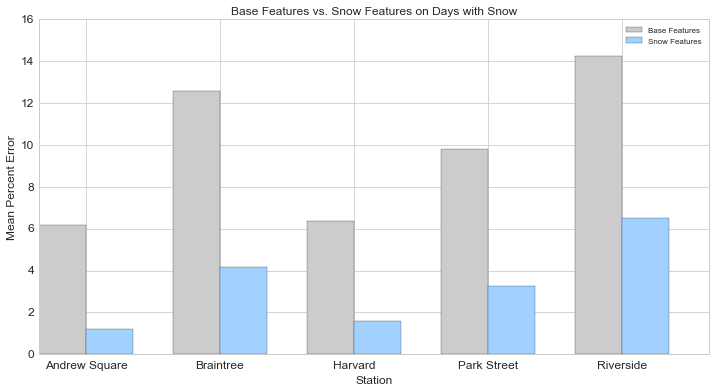

In [157]:
sub_results = results[(results['name'] == "Andrew Square") |
                      (results['name'] == "Riverside") |
                      (results['name'] == "Harvard") |
                      (results['name'] == "Park Street") |
                      (results['name'] == "Braintree")]

n = len(sub_results)

names = sub_results['name'].values
base_errors = sub_results['base_error'].values * 100
snow_errors = sub_results['extended_error'].values * 100

ind = np.arange(n)
width = .35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(ind, base_errors, width, color='#CCCCCC')
rects2 = ax.bar(ind+width, snow_errors, width, color='#A3D1FF')

ax.set_title('Base Features vs. Snow Features on Days with Snow')
ax.set_xlabel('Station')
ax.set_ylabel('Mean Percent Error')

ax.set_xticks(ind+width)
ax.set_xticklabels(names, {'size':'12'})

ax.legend( (rects1[0], rects2[0]), ('Base Features', 'Snow Features') )

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

##### Conclusion #####

By adding "snow" features to a base feature set, we were able to reduce our prediction error rate by ***2.3%*** across all stations.

## Conclusion ##

- *Does snow affect Ridership?* **Yes!**

    TODO: Details.
    
    TODO: Linear Trend Image?


- *How does understanding snow help the MBTA?* **Improve predictions and staffing process!**

    TODO: Details.